<a href="https://colab.research.google.com/github/avkornaev/Fast_AI_course/blob/main/IRI_defects_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Установка библиотек**

In [14]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

**Импорт библиотек**

In [15]:
from fastai.vision.all import *

**Загрузка данных**

In [16]:
path =  Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training')

In [17]:
path.ls()

(#2) [Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm'),Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Bad')]

Скачивание файлов изображений.

In [18]:
files = get_image_files(path)

In [19]:
len(files)

214

In [20]:
files[0],files[2]

(Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm/img_thermal_1637761638400.jpg'),
 Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm/img_thermal_1637761920622.jpg'))

**Создание датасета**

Используется DataBlock и DataLoader, которые считывает разметку данных с названия папки с помощью функции parent_label.



In [21]:
IRI_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label)

In [22]:
IRI_data = IRI_data.new(item_tfms=RandomResizedCrop(224, min_scale=0.3),batch_tfms=aug_transforms(mult=2))

In [23]:
dls = IRI_data.dataloaders(path)

Просмотр примера изображений

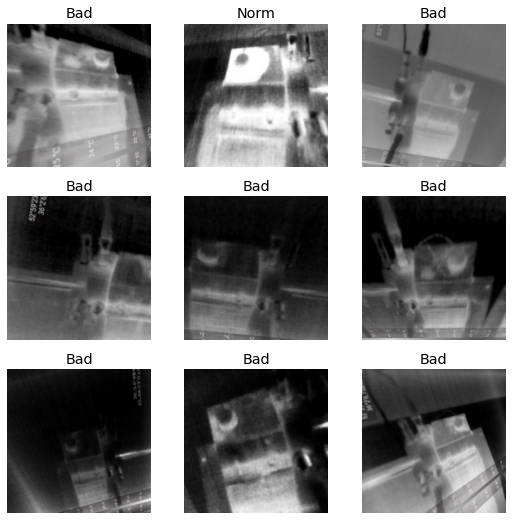

In [24]:
dls.show_batch()

**Обучение**

In [25]:
??cnn_learner

In [26]:
learn = cnn_learner(dls,resnet18,metrics=error_rate,pretrained=True)

Целевая функция

In [27]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Метод поиска экстремума

In [28]:
learn.opt_func

<function fastai.optimizer.Adam>

Подбор скорости обучения

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10)

**Результаты**

Предсказание для любого конкретного изображения

In [ ]:
learn.predict(files[101]),files[101]

Визуализация предсказаний.

In [ ]:
learn.show_results()

**Оценка точности**

Матрица ошибок

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

In [ ]:
Чувствительность

In [ ]:
sensitivity = tp/(tp + fn)
sensitivity

Специфичность

In [ ]:
specificity = tn/(fp + tn)
specificity

Positive Predictive Value (PPV)

In [ ]:
ppv = tp/(tp+fp)
ppv

Negative Predictive Value (NPV)

In [ ]:
npv = tn/(tn+fn)
npv

Calculating Accuracy

In [ ]:
acc = (tp+tn)/(tp+tn+fp+fn)

Ссылки:
https://github.com/avkornaev/Fast_AI_course/blob/main/02_production_v3_online.ipynb

https://docs.fast.ai/tutorial.medical_imaging.html

https://docs.fast.ai/data.block.html#DataBlock


